# Shady streets: Route-finding in the shade
Idea: build a route finder that finds the shortest path with the most shade - perfect tool for navigating by bike or by foot during a heatwave. Of course, someone has already done this, using LiDAR data: https://www.allnans.com/jekyll/update/2018/08/07/introducing-parasol.html

In [1]:
import geopandas as gpd
import rasterio 
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd

# Reading data
* tree point location - shpfile
* bike path - graphml, shpfile

In [47]:
treesGdf = gpd.read_file('data/trees_delft.shp')
bikeGraph = ox.io.load_graphml('data/bikePaths.graphml')
bikeGdfs = ox.utils_graph.graph_to_gdfs(bikeGraph)
bikeNodes = bikeGdfs[0]
bikeEdges = bikeGdfs[1]

# # add lists to cols
# colList = list(bikeEdges.columns)
# colList.remove('geometry')
# for col in colList: 
#     bikeEdges[col] = bikeEdges[col].map(lambda x: x.split(',') if ',' in str(x) else x)
# bikeEdges = bikeEdges.set_index(['u', 'v', 'key']) # correct format for converting into graph object

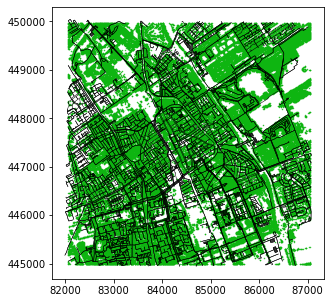

In [3]:
# test plot
fig, ax = plt.subplots(1,1,figsize=(5,5))
treesGdf.plot(ax=ax, markersize=0.2, color='#0eb511')
bikeEdges.plot(ax=ax, color='black', linewidth=0.5)
plt.show()

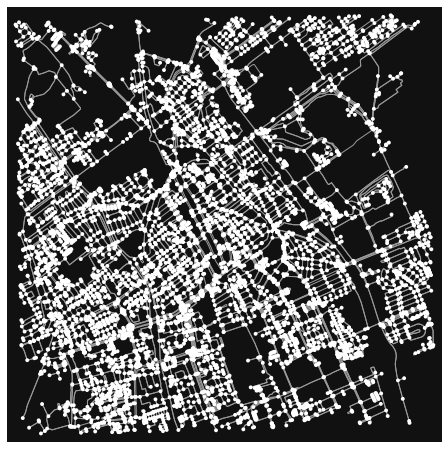

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
G_projected = ox.project_graph(bikeGraph)
ox.plot_graph(G_projected)

# Shortest path - normal
* shortest path for all bike paths
* shortest path for all bike paths with tree threshold

In [6]:
G = bikeGraph

In [7]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [4]:
# geocode orgin and destination address 
origAddress = 'Papenstraat 71, 2611 JB Delft'
destAddress = 'Prometheusplein 1, 2628 ZC Delft'

# geocode
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="shadyStreets")
origLoc = geolocator.geocode(origAddress)
destLoc = geolocator.geocode(destAddress)
print('origin\naddress: {} lat: {} lng: {}'.format(origAddress, origLoc.latitude, origLoc.longitude))
print('destination\naddress: {} lat: {} lng: {}'.format(destAddress, destLoc.latitude, destLoc.longitude))

origin
address: Papenstraat 71, 2611 JB Delft lat: 52.0126154 lng: 4.3573126
destination
address: Prometheusplein 1, 2628 ZC Delft lat: 52.002677 lng: 4.3752397


In [8]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=origLoc.longitude, Y=origLoc.latitude)
dest = ox.distance.nearest_nodes(G, X=destLoc.longitude, Y=destLoc.latitude)

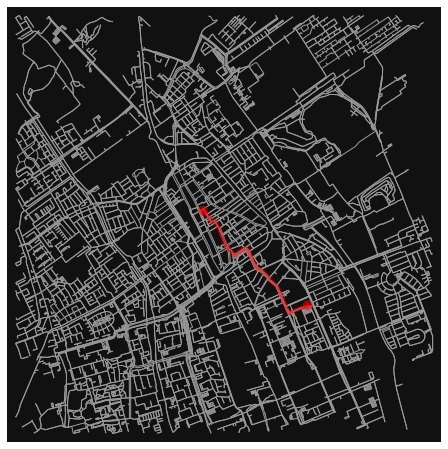

In [9]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [10]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))

2177

# Shortest path - shaded

## Create gdfs `shadedEdges` and `shadedNodes`
Previously, this took 11 minutes just to do just for Delft. The process was sped up to seconds, using the r-tree spatial indexing method. See links below for more details. 
* [notebook for rtree indexing](https://github.com/gboeing/ppd599/blob/2017/19-Spatial-Analysis-and-Cartography/rtree-spatial-indexing.ipynb)
* [blog on rtree indexsing](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/)

In [14]:
%%time
trees = treesGdf[treesGdf.trees > 50]
treesBuffer = trees.geometry.buffer(30).unary_union

# boundary of tree shadows
shadows = treesBuffer # multipolygon
shadowsGdf = gpd.GeoDataFrame(treesBuffer).rename(columns={0:'geometry'})

CPU times: total: 4.16 s
Wall time: 4.19 s


In [66]:
%%time
# prepare elements
bikeEdges_a = bikeEdges.to_crs('EPSG:28992').reset_index()
bikeNodes_a = bikeNodes.reset_index().to_crs('EPSG:28992')
shadows_cut = ox.utils_geo._quadrat_cut_geometry(shadows, quadrat_width=1000)
sindex = bikeEdges_a.sindex # build the r-tree index

CPU times: total: 1.09 s
Wall time: 1.11 s


In [68]:
%%time
# find the edges that intersect with each subpolygon and add them to points_within_geometry
points_within_geometry = pd.DataFrame()
for poly in shadows_cut.geoms:
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = bikeEdges_a.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    points_within_geometry = pd.concat([points_within_geometry, precise_matches])

CPU times: total: 7.97 s
Wall time: 7.99 s


In [77]:
shadedEdges = points_within_geometry
shadedNodeIds = list(shadedEdges.u) + list(shadedEdges.v)
shadedNodes = bikeNodes_a[bikeNodes_a.osmid.isin(shadedNodeIds)]

Shaded edges and nodes are shown below in green.

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


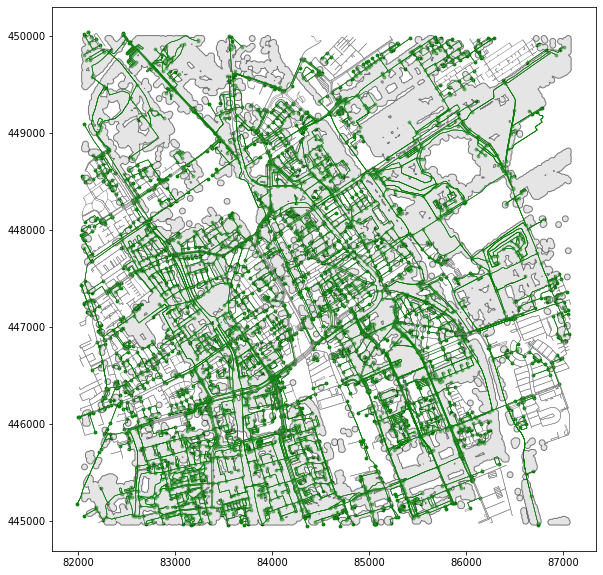

In [81]:
from descartes import PolygonPatch
fig, ax = plt.subplots(figsize=(10,10))
for polygon in shadows.geoms: 
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
bikeEdges_a.plot(ax=ax, color='grey', linewidth=0.5)
shadedEdges.plot(ax=ax, color='green', linewidth=0.5)
shadedNodes.plot(ax=ax, color='green', markersize=8)
plt.show()

## Calculate shortest path using new graph

In [225]:
# prepping gdfs to convert into graph
shadedNodes_g = shadedNodes.to_crs('EPSG:4326').set_index('osmid')
shadedEdges_g = shadedEdges.to_crs('EPSG:4326').set_index(['u', 'v', 'key'])

In [230]:
# covert gdf to graph
G_shaded = ox.utils_graph.graph_from_gdfs(shadedNodes_g, shadedEdges_g, graph_attrs=None)

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\osmnx\utils_graph.py:155: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


In [231]:
# impute missing edge speeds and calculate edge travel times with the speed module
G_shaded = ox.speed.add_edge_speeds(G_shaded)
G_shaded = ox.speed.add_edge_travel_times(G_shaded)

In [232]:
# geocode orgin and destination address 
origAddress = 'Papenstraat 71, 2611 JB Delft'
destAddress = 'Prometheusplein 1, 2628 ZC Delft'

# geocode
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="shadyStreets")
origLoc = geolocator.geocode(origAddress)
destLoc = geolocator.geocode(destAddress)
print('origin\nlat: {} lng: {}'.format(origLoc.latitude, origLoc.longitude))
print('destination\nlat: {} lng: {}'.format(destLoc.latitude, destLoc.longitude))

origin
lat: 52.0126154 lng: 4.3573126
destination
lat: 52.002677 lng: 4.3752397


In [235]:
# use a strongly (instead of weakly) connected graph
Gs = ox.utils_graph.get_largest_component(G_shaded, strongly=True)
orig = ox.distance.nearest_nodes(Gs, X=origLoc.longitude, Y=origLoc.latitude)
dest = ox.distance.nearest_nodes(Gs, X=destLoc.longitude, Y=destLoc.latitude)

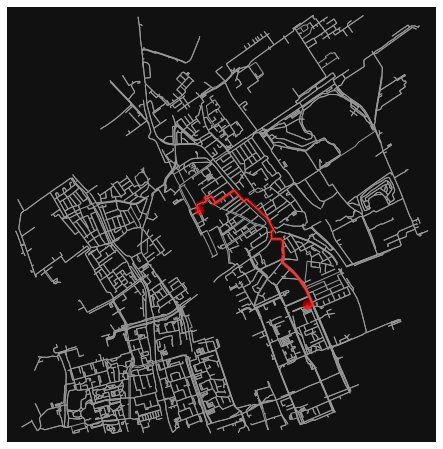

In [234]:
route = ox.shortest_path(Gs, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(Gs, route, node_size=0)

In [244]:
gsGdfs = ox.utils_graph.graph_to_gdfs(Gs)
gsNodes = gsGdfs[0]
gsEdges = gsGdfs[1]

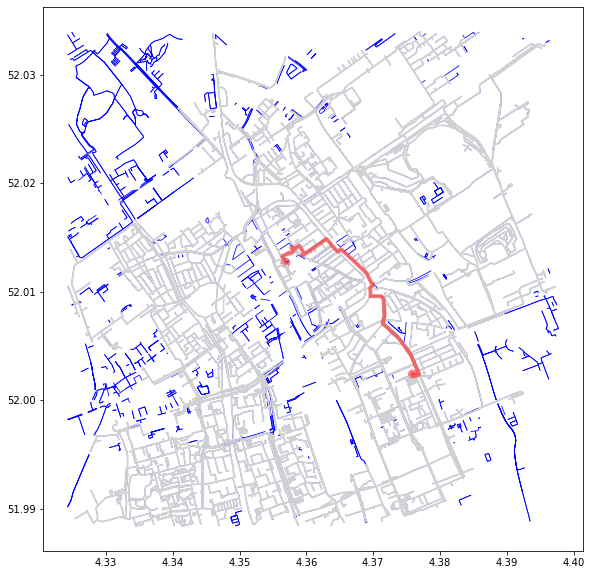

In [253]:
fig, ax = plt.subplots(figsize=(10,10))
shadedEdges_g.plot(ax=ax, color='blue', linewidth=0.8)
gsEdges.plot(ax=ax, color='lightgrey')
ox.plot_graph_route(Gs, route, node_size=0, ax=ax)
plt.show()

### Problem (solved): `ox.shortest_path` raises error 'NoneType' object is not scriptable

#### Troubleshooting 1 (checked): Check if shortest path would still work for original bikeEdge and node gdfs converted to graph file
It works, even if the crs has changed. The next step is to make sure that the formatting for `shadedEdges` and `shadedNodes` match that of `bikeEdges` and `bikeNodes`. 

In [6]:
# convert to gdf
bikeGraph = ox.io.load_graphml('data/bikePaths.graphml')
bikeGdfs = ox.utils_graph.graph_to_gdfs(bikeGraph)
bikeNodes = bikeGdfs[0]
bikeEdges = bikeGdfs[1]

In [7]:
G = ox.utils_graph.graph_from_gdfs(bikeNodes, bikeEdges, graph_attrs=None)

In [8]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [9]:
# geocode orgin and destination address 
origAddress = 'Papenstraat 71, 2611 JB Delft'
destAddress = 'Prometheusplein 1, 2628 ZC Delft'

# geocode
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="shadyStreets")
origLoc = geolocator.geocode(origAddress)
destLoc = geolocator.geocode(destAddress)
print('origin: {}\nlat: {} lng: {}'.format(origAddress, origLoc.latitude, origLoc.longitude))
print('destination: {}\nlat: {} lng: {}'.format(destAddress, destLoc.latitude, destLoc.longitude))

origin: Papenstraat 71, 2611 JB Delft
lat: 52.0126154 lng: 4.3573126
destination: Prometheusplein 1, 2628 ZC Delft
lat: 52.002677 lng: 4.3752397


In [10]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=origLoc.longitude, Y=origLoc.latitude)
dest = ox.distance.nearest_nodes(G, X=destLoc.longitude, Y=destLoc.latitude)

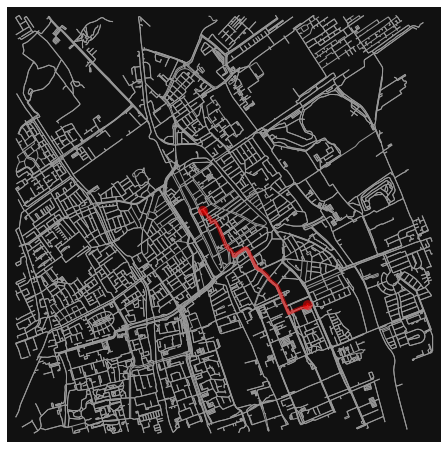

In [11]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

#### Troubleshooting 2: Check formatting of `shadedNodes` and `shadedEdges` 
Do they look similar to `bikeNodes` and `bikeEdges`? Extract node and edge gdfs from graph that successfully calculated shortest path, and see if they have the same formatting as `shadedNodes` and `shadedEdges`. 

`shadedNodes` and `bikeNodes` seem to have the same format, see below

In [148]:
shadedNodes_g.head()

y         x  street_count highway  ref  \
osmid                                                      
21748385  52.032815  4.395728             3     NaN  NaN   
21748388  52.029774  4.387599             4     NaN  NaN   
25315531  52.022649  4.374519             4     NaN  NaN   
25315553  52.021946  4.387287             4     NaN  NaN   
25315558  52.023895  4.375116             3     NaN  NaN   

                          geometry  
osmid                               
21748385  POINT (4.39573 52.03282)  
21748388  POINT (4.38760 52.02977)  
25315531  POINT (4.37452 52.02265)  
25315553  POINT (4.38729 52.02195)  
25315558  POINT (4.37512 52.02389)

In [149]:
shadedEdges_g.head()

osmid        name        highway  oneway  \
u          v          key                                                 
7670387566 1833073765 0    172400717         NaN           path   False   
1833073765 7670387566 0    172400717         NaN           path   False   
1568976500 44768467   0      7541359  Mozartlaan       tertiary   False   
           44770870   0      7541299   Elgarlaan  living_street   False   
44770870   1568976500 0      7541299   Elgarlaan  living_street   False   

                           length bridge width  \
u          v          key                        
7670387566 1833073765 0    42.724    NaN   NaN   
1833073765 7670387566 0    42.724    NaN   NaN   
1568976500 44768467   0    87.421    NaN   NaN   
           44770870   0    69.936    NaN   NaN   
44770870   1568976500 0    69.936    NaN   NaN   

                                                                    geometry  \
u          v          key                                                      
7670387566 1833073765 0      LINESTRING (4.33687 51.99261, 4.33748 51.99269)   
1833073765 7670387566 0      LINESTRING (4.33748 51.99269, 4.33687 51.99261)   
1568976500 44768467   0    LINESTRING (4.33583 51.99311, 4.33605 51.99313...   
           44770870   0    LINESTRING (4.33583 51.99311, 4.33583 51.99323...   
44770870   1568976500 0    LINESTRING (4.33574 51.99373, 4.33580 51.99350...   

                          maxspeed service lanes access tunnel  ref junction  \
u          v          key                                                      
7670387566 1833073765 0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
1833073765 7670387566 0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
1568976500 44768467   0         50     NaN   NaN    NaN    NaN  NaN      NaN   
           44770870   0         15     NaN   NaN    NaN    NaN  NaN      NaN   
44770870   1568976500 0         15     NaN   NaN    NaN    NaN  NaN      NaN   

                          est_width  
u          v          key            
7670387566 1833073765 0         NaN  
1833073765 7670387566 0         NaN  
1568976500 44768467   0         NaN  
           44770870   0         NaN  
44770870   1568976500 0         NaN

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_9176\1918523829.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  testEdge = shadedEdges_g.loc[(7670387566, 1833073765, 0)] # take random edge


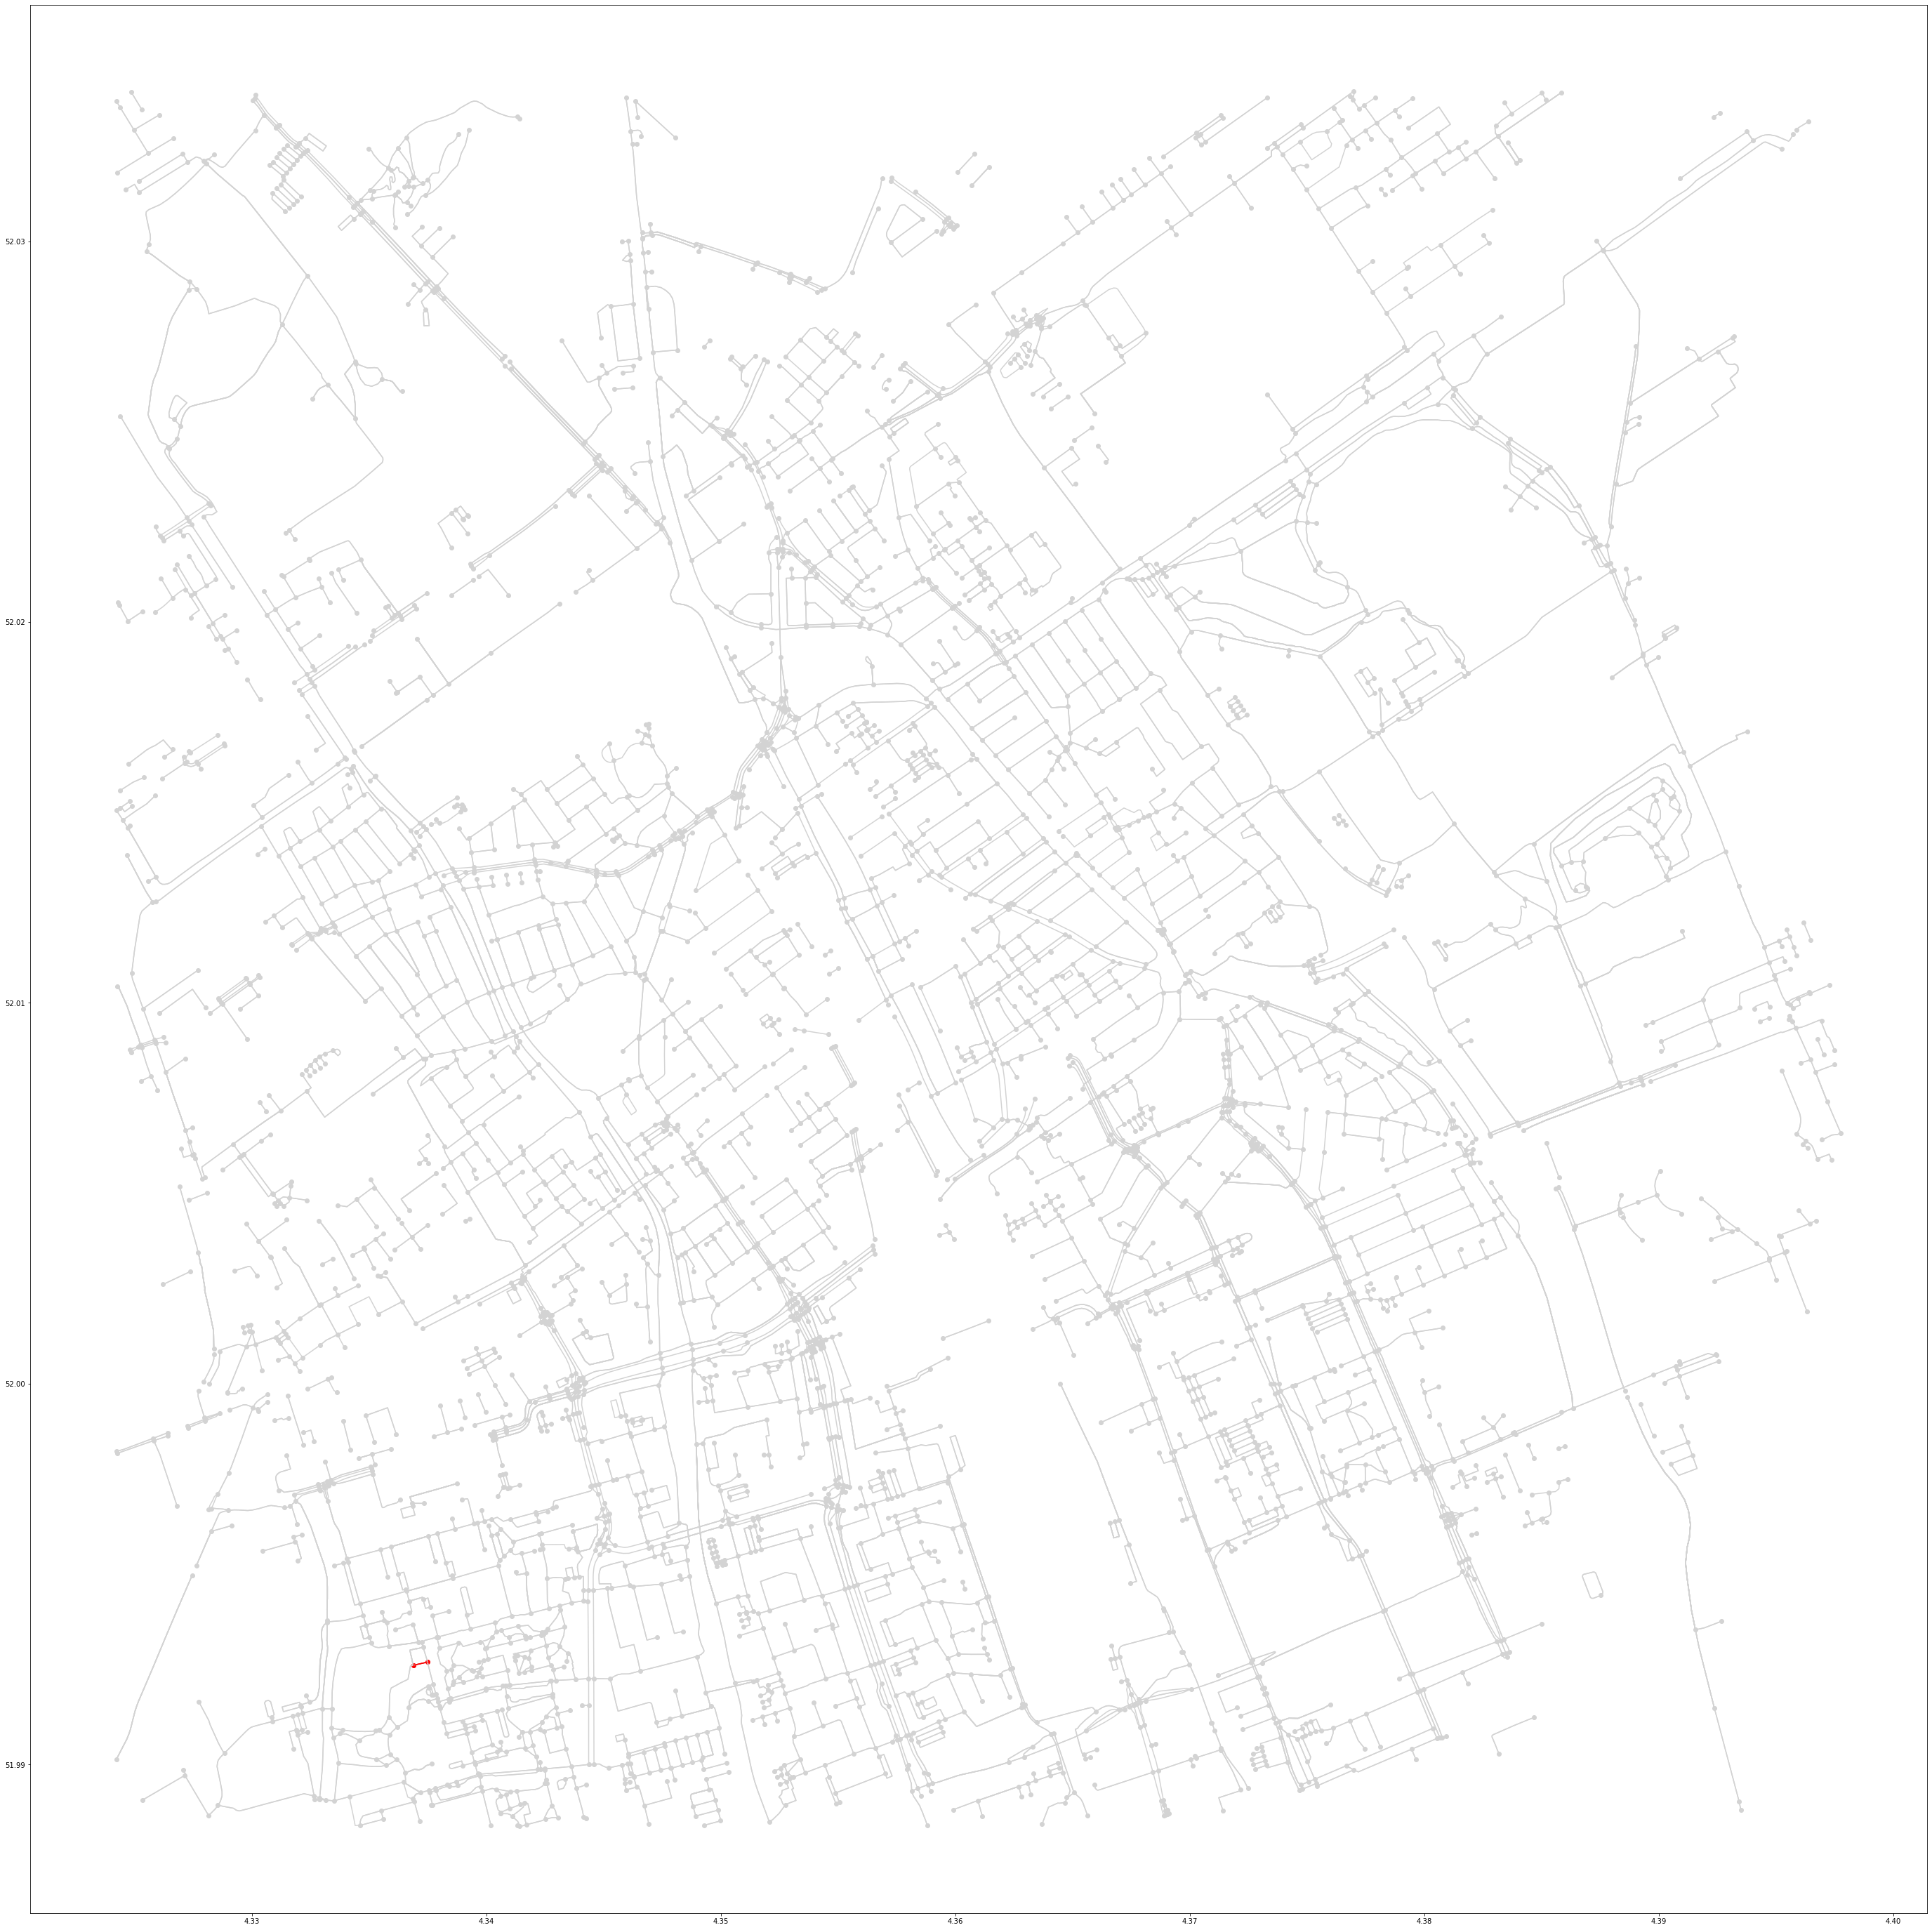

In [175]:
testEdge = shadedEdges_g.loc[(7670387566, 1833073765, 0)] # take random edge 
testNode = shadedNodes_g.loc[[7670387566, 1833073765]] # two nodes that the edge connects 
fig, ax = plt.subplots(figsize=(50,50))
shadedEdges_g.plot(ax=ax, color='lightgrey')
shadedNodes_g.plot(ax=ax, color='lightgrey')
testNode.plot(ax=ax, color='red')
testEdge.plot(ax=ax, color='red')
plt.show()

In [22]:
dtypeDict = {'col': shadedNodes.columns, 'shadedNodes': [], 'bikeNodes': []}
for i, gdf in enumerate([shadedNodes, bikeNodes]): 
    name = 'shadedNodes' if i==0 else 'bikeNodes'
    for col in gdf.columns: 
        dtypeDict[name].append(gdf[col].dtype)

pd.DataFrame(dtypeDict)

col shadedNodes bikeNodes
0             y     float64   float64
1             x     float64   float64
2  street_count       int64     int64
3       highway      object    object
4           ref      object    object
5      geometry    geometry  geometry

As seen below, `shadedEdges` and `bikeEdges` seem to have the same format columns

In [23]:
dtypeDict = {'col': shadedEdges.columns, 'shadedEdges': [], 'bikeEdges': []}
for i, gdf in enumerate([shadedEdges, bikeEdges]): 
    name = 'shadedEdges' if i==0 else 'bikeEdges'
    for col in gdf.columns: 
        dtypeDict[name].append(gdf[col].dtype)

pd.DataFrame(dtypeDict)

col shadedEdges bikeEdges
0       osmid      object    object
1        name      object    object
2     highway      object    object
3      oneway        bool      bool
4      length     float64   float64
5      bridge      object    object
6       width      object    object
7    geometry    geometry  geometry
8    maxspeed      object    object
9     service      object    object
10      lanes      object    object
11     access      object    object
12     tunnel      object    object
13        ref      object    object
14   junction      object    object
15  est_width      object    object

#### Troubleshooting 3: is it an issue of too many missing edges? 
* it could be that there are too many dead-ends, which makes the graph think that the origin and destination points are not connected, when they could have been connected using a de-tour. See [stackoverflow discussion](https://stackoverflow.com/questions/63690631/osmnx-shortest-path-how-to-skip-node-if-not-reachable-and-take-the-next-neares)
* it could also be an issue of [graph directions](https://stackoverflow.com/questions/64671844/osmnx-is-it-possible-that-i-get-shortest-path-from-a-node-but-no-edge-is-conne)? 

The graph `G_shaded` indeed thinks that the two nodes `orig` and `dest` are not reachable, see error below.

In [134]:
nx.shortest_path_length(G_shaded, orig, dest, weight='traveltime')

NetworkXNoPath: Node 1385643246 not reachable from 44856079

**The solution** was to turn `G_shaded` into a strongly connected graph `Gs`. A strongly connected graph is where all nodes are connected to all nodes, see [YouTube explanation here](https://www.youtube.com/watch?v=2fzSEMNEXhU&ab_channel=WrathofMath). In other words, it means you can get from all locations to all locations on the map. 

In [224]:
# OPTION 2: use a strongly (instead of weakly) connected graph
Gs = ox.utils_graph.get_largest_component(G_shaded, strongly=True)
orig = ox.distance.nearest_nodes(Gs, X=origLoc.longitude, Y=origLoc.latitude)
dest = ox.distance.nearest_nodes(Gs, X=destLoc.longitude, Y=destLoc.latitude)

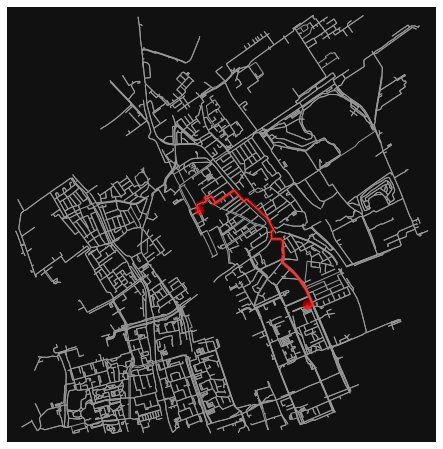

In [223]:
route = ox.shortest_path(Gs, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(Gs, route, node_size=0)